### 1. cMLP, cRNN, cLSTM
`-` cMLP

* 완전연결 신견망(MLP) 기반
* 과거의 관측값을 입력으로 받아 비선형 함수를 통해 출력 생성
* 시계열 데이터에서, 시간적 정보는 고려하지 않고 독립적인 입력변수로 다룸
* 장점 : 계산량이 적고 단순
* 단점 : 시계열 특성 고려x(순서정보 반영하지 못함)  $\to$ 장기 의존성 학습이 어려움
* $\hat{X}_{t+1}=f_{\theta}(X_t,X_{t-1},...,X_{t-k})$
    * $f_{\theta}$ : MLP, k : 과거 시점 개수

`-` cRNN

* 순환 신경망(RNN)을 기반, 시간 의존성 반영할 수 있음
* 과거 데이터의 상태를 **은닉 상태**에 저장하여 학습
* 장점 : 시계열 표현 잘 반영
* 단점 : 장기 의존성을 학습하기는 어려움(Vanishing Gradient 문제)
* $h_t=\sigma(W_th_{t-1}+W_xX_t)$
* $\hat{X}_{t+1}=f_{\theta}(h_t)$
* $h_t$ : 은닉 상태, $W_t, W_x$ 는 가중치 행렬, $\sigma$ 는 활성화 함수

`-` cLSTM

* 장기-단기 기억 네트워크를 기반으로 한 모델
* RNN 단점인 Vanishing Gradient 문제를 해결하여 장기 의존성 학습 가능
* 셀 상태와 게이트 구조를 사용하여 중요한 정보만 저장하고 불필요한 정보 삭제
* 단점 : 연산량이 많아 학습속도가 느릴 수 있음
* $f_t = \sigma(W_f[h_{t-1},X_t]+b_f$
* $i_t = \sigma(W_i[h_{t-1},X_t]+b_i$
* $o_t = \sigma(W_o[h_{t-1},X_t]+b_o$
* $C_t=f_t \odot C_{t-1}+i_t \odot \tilde{C}_t$
* $h_t=o_t\odot tanh(C_t)$
* $f_t$ : forget gate, $i_t$ : input gate, $o_t$ : output gate, $C_t$ : 셀 상태

### [Neural Granger Causality Github](https://github.com/iancovert/Neural-GC)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.clstm import cLSTM, train_model_ista

In [10]:
import pandas as pd

In [2]:
# For GPU acceleration
device = torch.device('cuda')

`-` simulate_lorenz_96 함수는 Lorenz-96 모델을 시뮬레이션하여 데이터를 생성하는 함수

* 기상학과 동역학 시스템에서 사용되는 비선형 동적 시스템 모델
* 아래의 미분 방정식으로 정의
    * $\frac{dx_i}{dt}=(x_{i+1}-x_{i-2})x_{i-1}-x_i+F$
* 비선형 시스템으로 복잡한 시간적 변화를 모사
* 기상 모델링과 같은 분야에서 사용
* 혼돈 현상을 나타낼 수 있음
* p : 시스템의 차원(변수 개수), T: 시뮬레이션 시간길이, F : 외부 힘(혼돈 유발 파라미터)

In [71]:
# Simulate data
#X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
#X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [13]:
wt = pd.read_csv("weather2024.csv")

In [12]:
wt

,일시,기온,강수량,풍속,습도,일사
0,2024-01-01 01:00,3.8,0.0,1.5,80,0.0
1,2024-01-01 02:00,3.9,0.0,0.2,79,0.0
2,2024-01-01 03:00,3.5,0.0,0.4,84,0.0
3,2024-01-01 04:00,1.9,0.0,1.1,92,0.0
4,2024-01-01 05:00,1.4,0.0,1.5,94,0.0
...,...,...,...,...,...,...
8755,2024-12-30 20:00,7.6,0.0,1.4,71,0.0
8756,2024-12-30 21:00,7.5,0.0,1.7,69,0.0
8757,2024-12-30 22:00,7.2,0.0,1.2,70,0.0
8758,2024-12-30 23:00,7.2,0.0,1.7,71,0.0


`-` numpy 형태의 x,y지정

In [50]:
X_np = wt.iloc[:, 1:].values

`-` tensor형태로 변환

In [53]:
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [58]:
wt.columns

Index(['일시', '기온', '강수량', '풍속', '습도', '일사'], dtype='object')

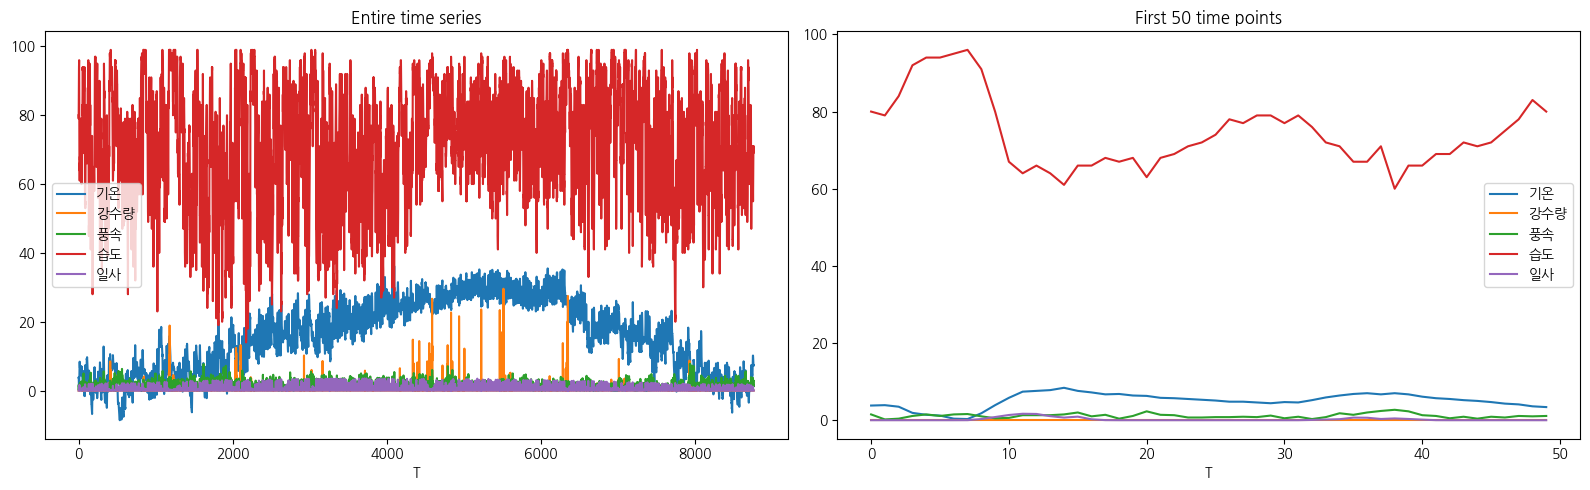

In [57]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

# 전체 시계열 데이터 (기온, 강수량, 풍속, 습도)
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[0].legend(wt.columns[1:])  # 범례 추가

# 처음 50개 타임스텝 데이터
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
axarr[1].legend(wt.columns[1:])  # 범례 추가

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()


`-` X.shape[-1] : 컬럼의 개수, 여기서는 5

`-` hidden : LSTM의 은닉 상태 크기

In [59]:
# Set up model
clstm = cLSTM(X.shape[-1], hidden=100).cuda(device=device)

`-` context=n : 과거 n개의 타임스텝을 고려하여 학습

`-` lam, lam_ridge : 정규화 관련 하이퍼파라미터..그대로 둬도 무방

`-` lr : learning rate

`-` max_iter : 최대 몇 번의 반복동안 학습할지

`-` check_every : 모델 학습 과정에서 일정 간격마다 검증을 수행하는 주기

In [60]:
# Train with ISTA
train_loss_list = train_model_ista(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=50)

----------Iter = 50----------
Loss = 113.947586
Variable usage = 100.00%
----------Iter = 100----------
Loss = 95.600487
Variable usage = 100.00%
----------Iter = 150----------
Loss = 85.747925
Variable usage = 28.00%
----------Iter = 200----------
Loss = 78.164307
Variable usage = 24.00%
----------Iter = 250----------
Loss = 80.287163
Variable usage = 32.00%
----------Iter = 300----------
Loss = 76.854881
Variable usage = 32.00%
----------Iter = 350----------
Loss = 70.780518
Variable usage = 28.00%
----------Iter = 400----------
Loss = 62.113892
Variable usage = 20.00%
----------Iter = 450----------
Loss = 67.783348
Variable usage = 20.00%
----------Iter = 500----------
Loss = 68.171379
Variable usage = 28.00%
----------Iter = 550----------
Loss = 65.656067
Variable usage = 20.00%
----------Iter = 600----------
Loss = 57.279652
Variable usage = 24.00%
----------Iter = 650----------
Loss = 62.956081
Variable usage = 20.00%
----------Iter = 700----------
Loss = 60.115559
Variable usage

`-` 1000번 이하에서 early stopping이 발생

* loss값이 충분이 줄어들었거나
* loss 감소가 멈추었거나

`-` 이부분에서 데이터가 cuda 의 텐서여서 오류가 발생해 cpu, numpy로 변환

In [61]:
train_loss_np = np.array([loss.cpu().item() for loss in train_loss_list])

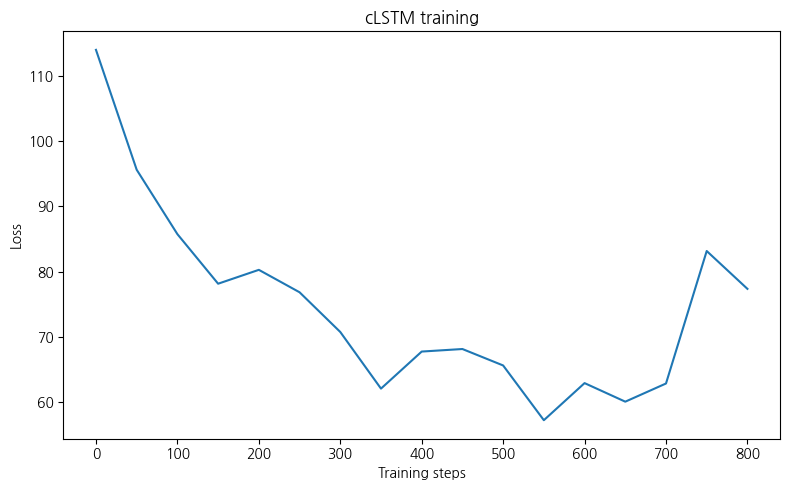

In [62]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_np)), train_loss_np)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

In [68]:
# 5개의 기상 변수 (기온, 강수량, 풍속, 습도, 일사)에 대한 GC 행렬
GC = np.array([[1, 1, 0, 0, 0],  # 기온 -> 강수량
               [0, 1, 1, 0, 0],  # 강수량 -> 풍속
               [0, 0, 1, 1, 0],  # 풍속 -> 습도
               [0, 0, 0, 1, 1],  # 습도 -> 일사
               [0, 0, 0, 0, 1]])  # 일사 -> 기온 (self loop)

True variable usage = 36.00%
Estimated variable usage = 24.00%
Accuracy = 64.00%


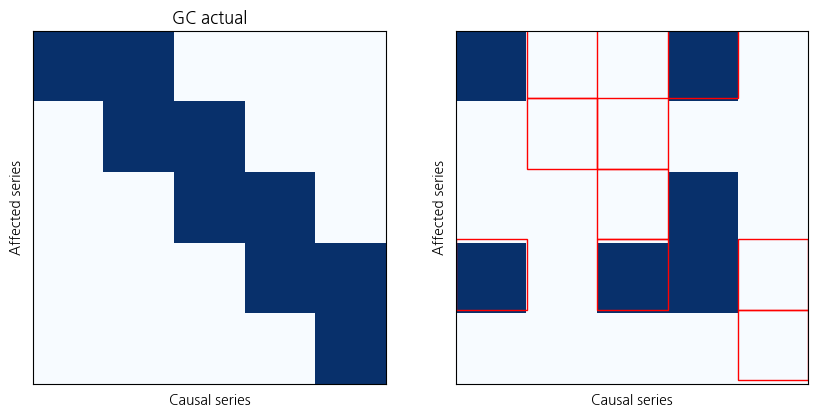

In [70]:
# Check learned Granger causality
GC_est = clstm.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

`-` Granger Causality

* 순서 : (기온 강수량 풍속 습도 일사)
* GC 실제 변수 간의 인과 관계, GC_est 학습된 모델이 추정한 인과 관계
* 실제 GC와 추정된 GC_est를 비교하여 정확도(accuracy) 계산
* 불일치하는 인과관계는 빨간색으로 표시

* 실제 GC를 어떻게 설정해야하지.....
* 왜이렇게 많이 틀렸지?? 뭔가 잘못 됐나